In [1]:
import pandas as pd
df=pd.read_csv("weather_data.csv")

In [2]:
df

,city,lat,lon,humidity,wind_mps,temp_celsius,date_time,weather,description,risk_level
0,Delhi,28.6667,77.2167,63,0.00,16.1,2025-11-08 17:15:13,Haze,haze,Low
1,Mumbai,19.0144,72.8479,54,2.57,28.0,2025-11-08 17:13:31,Smoke,smoke,Low
2,Bhopal,23.2667,77.4000,35,2.25,16.7,2025-11-08 17:19:35,Clear,clear sky,Low
3,Indore,22.7179,75.8333,48,2.06,17.1,2025-11-08 17:22:53,Haze,haze,Low
4,Bengaluru,12.9762,77.6033,72,3.13,20.6,2025-11-08 17:15:00,Clouds,few clouds,Low
...,...,...,...,...,...,...,...,...,...,...
710,Delhi,28.6667,77.2167,53,3.09,23.0,2025-11-13 06:26:54,Smoke,smoke,Low
711,Mumbai,19.0144,72.8479,37,4.12,30.0,2025-11-13 06:28:08,Smoke,smoke,Low
712,Bhopal,23.2667,77.4000,20,1.03,25.1,2025-11-13 06:33:20,Haze,haze,Low
713,Indore,22.7179,75.8333,32,2.57,27.1,2025-11-13 06:27:50,Clear,clear sky,Low


In [3]:
df_city = df[df["city"] == "Bhopal"].sort_values("date_time").reset_index(drop=True)

In [4]:
df_city

,city,lat,lon,humidity,wind_mps,temp_celsius,date_time,weather,description,risk_level
0,Bhopal,23.2667,77.4,35,2.25,16.7,2025-11-08 17:19:35,Clear,clear sky,Low
1,Bhopal,23.2667,77.4,34,2.06,17.1,2025-11-08 17:36:44,Haze,haze,Low
2,Bhopal,23.2667,77.4,26,1.03,22.1,2025-11-09 04:12:47,Haze,haze,Low
3,Bhopal,23.2667,77.4,26,1.03,22.1,2025-11-09 04:12:47,Haze,haze,Low
4,Bhopal,23.2667,77.4,26,1.03,22.1,2025-11-09 04:12:47,Haze,haze,Low
...,...,...,...,...,...,...,...,...,...,...
138,Bhopal,23.2667,77.4,30,1.54,22.1,2025-11-11 04:40:01,Haze,haze,Low
139,Bhopal,23.2667,77.4,27,1.54,23.1,2025-11-11 05:08:55,Clear,clear sky,Low
140,Bhopal,23.2667,77.4,25,2.06,24.1,2025-11-11 05:37:00,Haze,haze,Low
141,Bhopal,23.2667,77.4,20,1.03,25.1,2025-11-13 06:33:20,Haze,haze,Low


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
temp_data = df_city[["temp_celsius","humidity", "wind_mps"]].values  
temp_scaled=scaler.fit_transform(temp_data)
temp_scaled.shape


(143, 3)

In [6]:
import numpy as np
# Function to create input sequences and target values for LSTM
def create_dataset(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:(i + lookback), :])   # last 30 values as features
        y.append(data[i + lookback, 0])       # next value as target
    return np.array(X), np.array(y)

# Create dataset with lookback window (30 rows predict next one)
lookback = 60
X, y = create_dataset(temp_scaled, lookback)

print(f"Input shape: {X.shape}")
print(f"Target shape: {y.shape}")


Input shape: (83, 60, 3)
Target shape: (83,)


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape

(66, 60, 3)

In [8]:
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 3))
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 3))
# X_train.shape

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),

    LSTM(64,return_sequences=True),
    Dropout(0.2),

    LSTM(32),
    Dropout(0.2),

    Dense(16, activation='relu'),
    Dense(1)  # Output: next temp
])

model.compile(optimizer='adam', loss='mse')
model.summary()


C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 128)             │          67,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 129,953 (507.63 KB)

 Trainable params: 129,953 (507.63 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(X_train, y_train,epochs=100,batch_size=2,validation_data=(X_test, y_test),verbose=1)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 0.0831 - val_loss: 0.0670
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0665 - val_loss: 0.0954
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0450 - val_loss: 0.0788
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0622 - val_loss: 0.0606
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0507 - val_loss: 0.0693
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0483 - val_loss: 0.0572
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0565 - val_loss: 0.0623
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0417 - val_loss: 0.0581
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0401 - val_loss: 0.0327
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0343 - val_loss: 0.0349
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0324 - val_loss: 0.0440
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/st

In [11]:
# Make predictions
y_pred = model.predict(X_test)

# Reverse scale only temperature
temp_min = scaler.data_min_[0]
temp_max = scaler.data_max_[0]

y_test_actual = y_test * (temp_max - temp_min) + temp_min
y_pred_actual = y_pred * (temp_max - temp_min) + temp_min

print(y_test_actual, y_pred_actual)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
[25.1 18.1 24.1 20.1 16.1 15.1 23.1 20.1 25.1 21.1 24.1 24.1 17.1 21.1
 26.1 19.1 20.1] [[24.521708]
 [17.746588]
 [20.04541 ]
 [20.902351]
 [16.376513]
 [21.442928]
 [22.672283]
 [18.496685]
 [23.518084]
 [22.241758]
 [24.120193]
 [24.606144]
 [17.231188]
 [21.886147]
 [21.610796]
 [20.04968 ]
 [20.581087]]


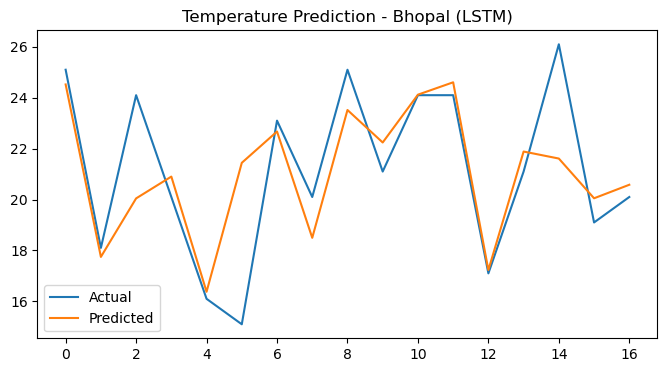

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(y_test_actual, label="Actual")
plt.plot(y_pred_actual, label="Predicted")
plt.legend()
plt.title("Temperature Prediction - Bhopal (LSTM)")
plt.show()


In [13]:
# ✅ Save LSTM model in new format
model.save("LSTM.keras")

# ✅ Save scaler
import joblib
joblib.dump(scaler, "scaler.pkl")

print("Model & Scaler Saved ✅")


Model & Scaler Saved ✅


In [14]:
from tensorflow.keras.models import load_model
import joblib

# ✅ Load model (no compile issues)
model = load_model("LSTM.keras", compile=False)

# ✅ Load scaler
scaler = joblib.load("scaler.pkl")

print("Model & Scaler Loaded ✅")

Model & Scaler Loaded ✅
